## Import lib

In [ ]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## Create dataframes

In [ ]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/kaggle/input/fundus-pytorch/train'
folder_list = os.listdir(train_path)
label_map = {
    "0":"Glaucoma Present",
    "1":"Glaucoma not Present",
}
for folder in label_map:
    img_path = os.path.join(train_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)



In [ ]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/kaggle/input/fundus-pytorch/val'
for folder in label_map:
    img_path = os.path.join(val_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [ ]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = '/kaggle/input/fundus-pytorch/test'
for folder in label_map:
    img_path = os.path.join(test_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

In [ ]:
train_df.head()

,path,label,class_id
0,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0
1,/kaggle/input/fundus-pytorch/train/0/REFUGE1-t...,Glaucoma Present,0
2,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0
3,/kaggle/input/fundus-pytorch/train/0/PAPILA-38...,Glaucoma Present,0
4,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


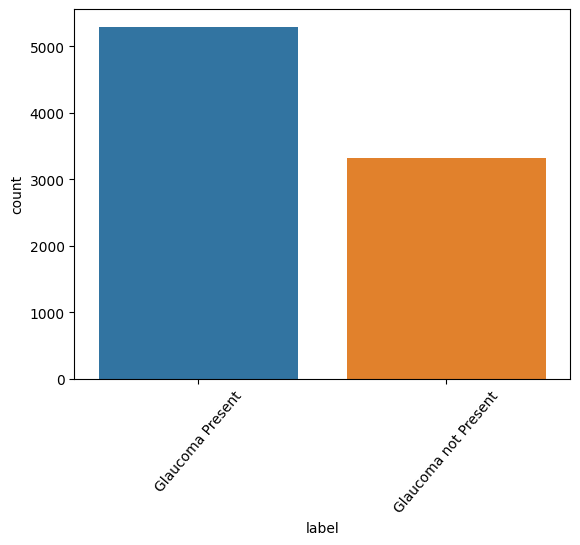

In [ ]:
sns.countplot(x = train_df["label"])
plt.xticks(rotation = 50);

## Show images

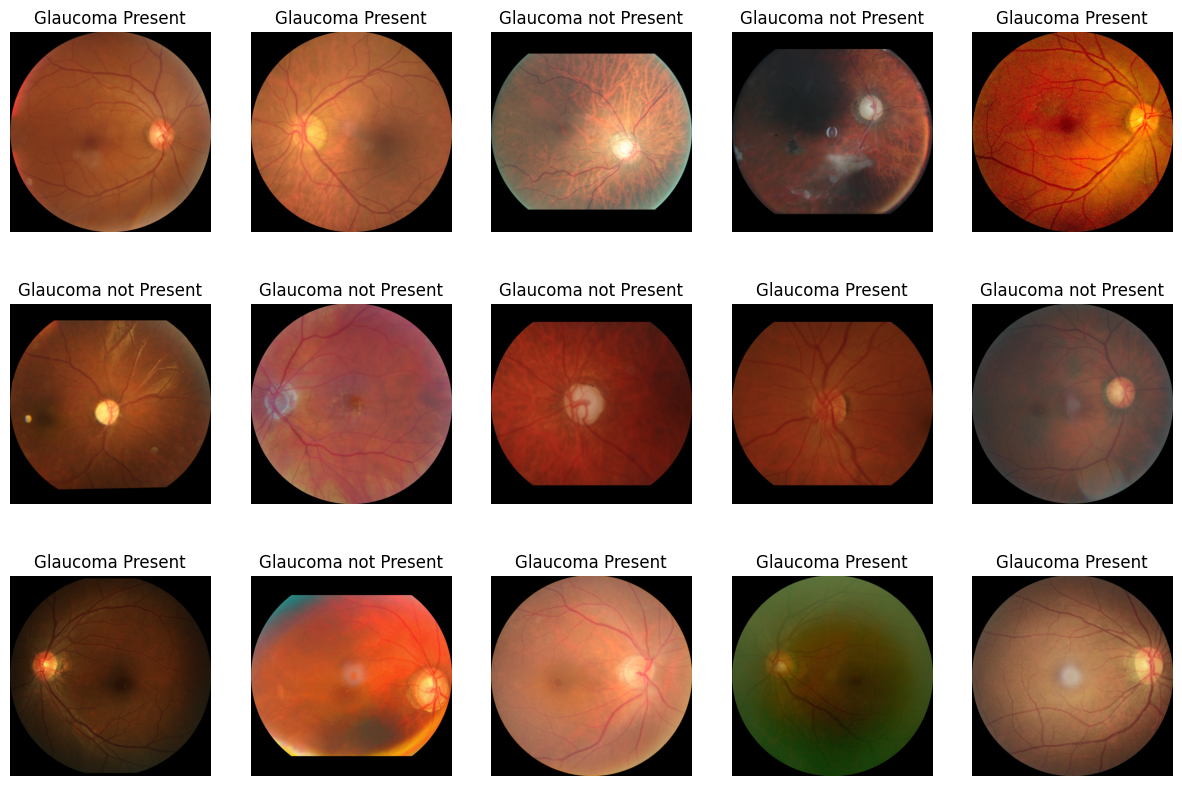

In [ ]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Create dataset and dataloader

In [ ]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
test_dataset = MyDataset(test_df, test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:8621
val data:5747


## Create model

In [ ]:
class_size = 2
# model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
model = models.efficientnet_v2_s(weights='DEFAULT')
# model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(1280, class_size)
model(torch.randn((16,3,256,256))).shape

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 237MB/s]


torch.Size([16, 2])

## Traning and validation

In [ ]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)

        # First we'll clean the cache of optimizer
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(data_)

        # Computing loss
        loss = loss_fn(outputs,target_)

        # Backward propagation
        loss.backward()

        # Optimizing model
        optimizer.step()

        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)

            # Computing loss
            loss = loss_fn(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [ ]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

criterion  = nn.CrossEntropyLoss()


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "checkpoints/last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.4912, train_acc: 0.762     val_loss: 0.3638, val_acc: 0.842     Learning Rate: 0.0001


  2%|▏         | 1/50 [06:12<5:04:13, 372.53s/it]

EPOCH: 1     train_loss: 0.4030, train_acc: 0.818     val_loss: 0.2890, val_acc: 0.876     Learning Rate: 0.0001


  4%|▍         | 2/50 [10:38<4:07:40, 309.59s/it]

EPOCH: 2     train_loss: 0.3743, train_acc: 0.839     val_loss: 0.2702, val_acc: 0.883     Learning Rate: 0.0001


  6%|▌         | 3/50 [15:04<3:47:07, 289.94s/it]

EPOCH: 3     train_loss: 0.3540, train_acc: 0.839     val_loss: 0.2586, val_acc: 0.894     Learning Rate: 0.0001


  8%|▊         | 4/50 [19:30<3:35:01, 280.46s/it]

EPOCH: 4     train_loss: 0.3479, train_acc: 0.846     val_loss: 0.2437, val_acc: 0.896     Learning Rate: 0.0001


 10%|█         | 5/50 [24:06<3:29:11, 278.92s/it]

EPOCH: 5     train_loss: 0.3251, train_acc: 0.860     val_loss: 0.2092, val_acc: 0.909     Learning Rate: 0.0001


 12%|█▏        | 6/50 [28:42<3:23:39, 277.73s/it]

EPOCH: 6     train_loss: 0.3144, train_acc: 0.862     val_loss: 0.2063, val_acc: 0.915     Learning Rate: 1e-05


 14%|█▍        | 7/50 [33:14<3:17:52, 276.12s/it]

EPOCH: 7     train_loss: 0.2856, train_acc: 0.879     val_loss: 0.1867, val_acc: 0.922     Learning Rate: 1e-05


 16%|█▌        | 8/50 [38:04<3:16:22, 280.53s/it]

EPOCH: 8     train_loss: 0.2828, train_acc: 0.882     val_loss: 0.1814, val_acc: 0.925     Learning Rate: 1e-05


 18%|█▊        | 9/50 [42:37<3:09:58, 278.01s/it]

EPOCH: 9     train_loss: 0.2678, train_acc: 0.883     val_loss: 0.1745, val_acc: 0.925     Learning Rate: 1e-05


 20%|██        | 10/50 [47:10<3:04:16, 276.42s/it]

EPOCH: 10     train_loss: 0.2698, train_acc: 0.879     val_loss: 0.1695, val_acc: 0.926     Learning Rate: 1e-05


 22%|██▏       | 11/50 [51:40<2:58:21, 274.39s/it]

EPOCH: 11     train_loss: 0.2712, train_acc: 0.883     val_loss: 0.1676, val_acc: 0.928     Learning Rate: 1e-05


 24%|██▍       | 12/50 [56:11<2:53:09, 273.42s/it]

EPOCH: 12     train_loss: 0.2603, train_acc: 0.884     val_loss: 0.1626, val_acc: 0.930     Learning Rate: 1e-05


 26%|██▌       | 13/50 [1:00:42<2:48:13, 272.81s/it]

EPOCH: 13     train_loss: 0.2509, train_acc: 0.889     val_loss: 0.1573, val_acc: 0.932     Learning Rate: 1.0000000000000002e-06


 28%|██▊       | 14/50 [1:05:16<2:43:52, 273.12s/it]

EPOCH: 14     train_loss: 0.2528, train_acc: 0.892     val_loss: 0.1578, val_acc: 0.933     Learning Rate: 1.0000000000000002e-06


 30%|███       | 15/50 [1:09:46<2:38:41, 272.05s/it]

EPOCH: 15     train_loss: 0.2455, train_acc: 0.894     val_loss: 0.1582, val_acc: 0.929     Learning Rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [1:14:13<2:33:21, 270.62s/it]

EPOCH: 16     train_loss: 0.2500, train_acc: 0.895     val_loss: 0.1578, val_acc: 0.934     Learning Rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [1:18:43<2:28:45, 270.47s/it]

EPOCH: 17     train_loss: 0.2509, train_acc: 0.892     val_loss: 0.1550, val_acc: 0.933     Learning Rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [1:23:08<2:23:26, 268.96s/it]

EPOCH: 18     train_loss: 0.2516, train_acc: 0.889     val_loss: 0.1550, val_acc: 0.935     Learning Rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [1:27:37<2:18:50, 268.72s/it]

EPOCH: 19     train_loss: 0.2487, train_acc: 0.892     val_loss: 0.1535, val_acc: 0.933     Learning Rate: 1.0000000000000002e-06


 40%|████      | 20/50 [1:32:04<2:14:13, 268.45s/it]

EPOCH: 20     train_loss: 0.2491, train_acc: 0.889     val_loss: 0.1534, val_acc: 0.935     Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [1:36:31<2:09:28, 267.87s/it]

EPOCH: 21     train_loss: 0.2425, train_acc: 0.894     val_loss: 0.1551, val_acc: 0.933     Learning Rate: 1.0000000000000002e-07


 44%|████▍     | 22/50 [1:40:57<2:04:41, 267.19s/it]

EPOCH: 22     train_loss: 0.2504, train_acc: 0.888     val_loss: 0.1534, val_acc: 0.934     Learning Rate: 1.0000000000000002e-07


 46%|████▌     | 23/50 [1:45:21<1:59:54, 266.47s/it]

EPOCH: 23     train_loss: 0.2511, train_acc: 0.892     val_loss: 0.1535, val_acc: 0.935     Learning Rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [1:49:48<1:55:27, 266.44s/it]

EPOCH: 24     train_loss: 0.2456, train_acc: 0.892     val_loss: 0.1540, val_acc: 0.932     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [1:54:18<1:51:32, 267.71s/it]

EPOCH: 25     train_loss: 0.2480, train_acc: 0.889     val_loss: 0.1539, val_acc: 0.933     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [1:58:47<1:58:47, 285.11s/it]

Earlystop!


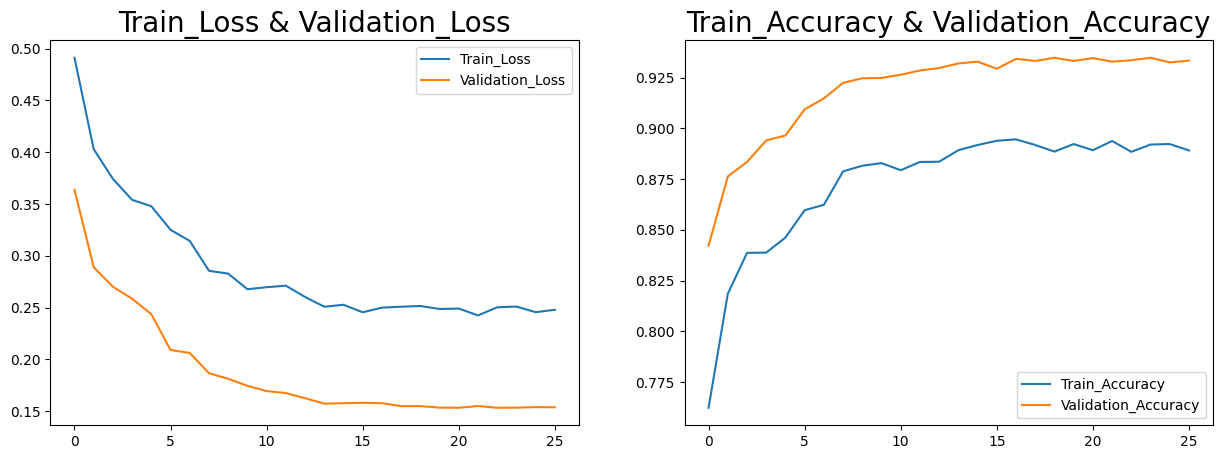

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## Metrics

In [ ]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (data_,target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs,dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)


100%|██████████| 90/90 [01:01<00:00,  1.46it/s]


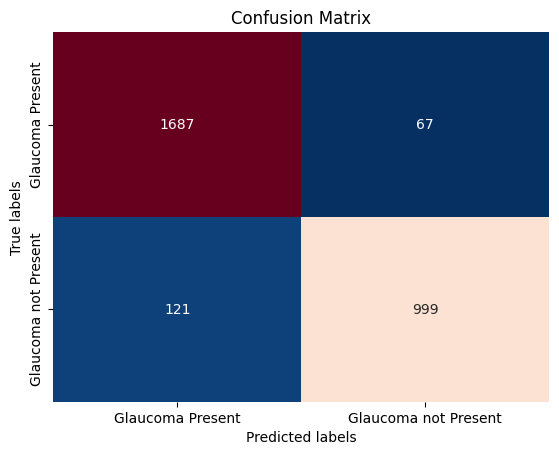

In [ ]:
label_list = ["Glaucoma Present", "Glaucoma not Present"]
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)
print(clf_report)

                      precision    recall  f1-score   support

    Glaucoma Present       0.93      0.96      0.95      1754
Glaucoma not Present       0.94      0.89      0.91      1120

            accuracy                           0.93      2874
           macro avg       0.94      0.93      0.93      2874
        weighted avg       0.93      0.93      0.93      2874



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the model architecture for EfficientNet V2
class GlaucomaDetectionModel(nn.Module):
    def __init__(self):
        super(GlaucomaDetectionModel, self).__init__()
        # Load EfficientNet V2 (we're using efficientnet_v2_s)
        self.features = models.efficientnet_v2_s(pretrained=False).features  # Use the features directly

        # Placeholder for classifier; we will define it after determining the number of features dynamically
        self.classifier = None

    def forward(self, x):
        x = self.features(x)  # Pass through feature extractor
        x = torch.flatten(x, 1)  # Flatten the output
        if self.classifier is None:
            # Dynamically define the classifier after knowing the number of input features
            num_ftrs = x.shape[1]
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(num_ftrs, 2)  # Binary classification (2 classes)
            )
        x = self.classifier(x)
        return x

def load_model(model_path):
    # Initialize the model architecture
    model = GlaucomaDetectionModel()

    # Load the saved model weights, allowing for flexibility in the state dictionary
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)

    # Set the model to evaluation mode
    model.eval()
    return model

def preprocess_image(image_path, input_size=(224, 224)):
    # Preprocess the image to be fed into the model
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Open and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def predict_glaucoma(model, image_tensor):
    # Perform the forward pass and get the prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Print confidence levels
    print(f"Confidence levels: {probabilities}")

    # Binary classification (0: Glaucoma, 1: No Glaucoma)
    if predicted.item() == 0:
        return "Glaucoma Detected"
    else:
        return "No Glaucoma Detected"


def predict_from_user_input(model_path):
    # Load the trained model
    model = load_model(model_path)

    # Ask the user to provide the image path
    image_path = input("Please provide the path to the input image: ").strip()

    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        return

    # Preprocess the image
    image_tensor = preprocess_image(image_path)

    # Get the prediction from the model
    prediction = predict_glaucoma(model, image_tensor)

    return prediction

# Usage:
model_path = '/content/drive/My Drive/LYProject/best.pth'

# Predict glaucoma based on user input
result = predict_from_user_input(model_path)
if result:
    print(f"Prediction: {result}")

ValueError: mount failed